In [3]:
import torch
import torch.nn.functional as F

def gradient_loss(input_image, target_image):
    # Define the convolution kernels for gradient extraction
    C_G = torch.tensor([
        [[[-1, 0, 0], [0, 1, 0], [0, 0, 0]]],
        [[[0, -1, 0], [0, 1, 0], [0, 0, 0]]],
        [[[0, 0, -1], [0, 1, 0], [0, 0, 0]]],
        [[[0, 0, 0], [-1, 1, 0], [0, 0, 0]]],
        [[[0, 0, 0], [0, 1, -1], [0, 0, 0]]],
        [[[0, 0, 0], [0, 1, 0], [-1, 0, 0]]],
        [[[0, 0, 0], [0, 1, 0], [0, -1, 0]]],
        [[[0, 0, 0], [0, 1, 0], [0, 0, -1]]]
    ]).float()
    
    pixel_loss = torch.abs(input_image - target_image).mean()
    # Expand the convolution kernels for RGB channels
    C_G = C_G.expand(-1, 3, -1, -1)

    input_gradients = F.conv2d(input_image, C_G, padding=1)
    target_gradients = F.conv2d(target_image, C_G, padding=1)

    diff = torch.abs(input_gradients - target_gradients)

    # Sum all differences
    gradient_loss = torch.sum(diff, dim=1).mean()
    print(pixel_loss, gradient_loss)
    g_loss = pixel_loss + gradient_loss
    return g_loss


import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable
from torch.nn import HuberLoss, SmoothL1Loss

class GLoss(nn.Module):
    def __init__(self, 
                device, 
                downsample_ratios: Iterable=[2, 4, 5],
                avg_pool_coeffs: Iterable=[0., 0., 0.],
                max_pool_coeffs: Iterable=[0., 0., 0.],
                splitting_coeffs: Iterable=[1 / 4., 1 / 16., 0.],
                p: int=1, EPS: float=1e-17,
                delta: float=1.35,
                beta: float=1e-6):
        super(GLoss, self).__init__()
        self.device = device
        self.gradient_kernel = torch.tensor([
                [[[-1, 0, 0], [0, 1, 0], [0, 0, 0]]],
                [[[0, -1, 0], [0, 1, 0], [0, 0, 0]]],
                [[[0, 0, -1], [0, 1, 0], [0, 0, 0]]],
                [[[0, 0, 0], [-1, 1, 0], [0, 0, 0]]],
                [[[0, 0, 0], [0, 1, -1], [0, 0, 0]]],
                [[[0, 0, 0], [0, 1, 0], [-1, 0, 0]]],
                [[[0, 0, 0], [0, 1, 0], [0, -1, 0]]],
                [[[0, 0, 0], [0, 1, 0], [0, 0, -1]]]
        ]).float().to(device)
        self.downsample_ratios = downsample_ratios
        self.avg_pool_coeffs = avg_pool_coeffs
        self.max_pool_coeffs = max_pool_coeffs
        self.splitting_coeffs = splitting_coeffs
        self.p = p
        self.EPS = EPS
        self.delta = delta
        self.beta = beta

    def forward(self, I, I_hat):
        # Calculate pixel loss
        # pixel_loss = torch.abs(I - I_hat).mean()
        pixel_loss = self.p_loss(I, I_hat)

        # Calculate gradient loss
        # gradient_loss = torch.abs(I_grad - I_hat_grad).mean()
        # gradient_loss = self.p_loss(I_grad, I_hat_grad)
        gradient_loss = self.gradient_loss(I, I_hat)

        avg_pool_loss = 0
        max_pool_loss = 0
        split_loss = 0
        # Calculate downsampling losses
        for i, n in enumerate(self.downsample_ratios):
            if self.avg_pool_coeffs[i] > 0:
                avg_pool_loss += self.avg_pool_coeffs[i] * self.gradient_loss(F.avg_pool2d(I, n), F.avg_pool2d(I_hat, n))
            if self.max_pool_coeffs[i] > 0:
                max_pool_loss += self.max_pool_coeffs[i] * self.gradient_loss(F.max_pool2d(I, n), F.max_pool2d(I_hat, n))
            if self.splitting_coeffs[i] > 0:
                split_loss += self.splitting_coeffs[i] * self.gradient_loss(self.splitting(I, n), self.splitting(I_hat, n))

        # Calculate the overall G-Loss
        g_loss = pixel_loss + gradient_loss + avg_pool_loss + max_pool_loss + split_loss
        # print(pixel_loss, gradient_loss, avg_pool_loss, max_pool_loss, split_loss)
        return g_loss

    def gradient_loss(self, I, I_hat):
        # Calculate gradient feature maps
        batch_size, channels, height, width = I.size()
        self.C_G = self.gradient_kernel.expand(-1, channels, -1, -1)
        I_grad = F.conv2d(I, self.C_G, padding=1)
        I_hat_grad = F.conv2d(I_hat, self.C_G, padding=1)

        # Calculate gradient loss
        # gradient_loss = torch.abs(I_grad - I_hat_grad).mean()
        gradient_loss = self.p_loss(I_grad, I_hat_grad)

        return gradient_loss

    def splitting(self, I, n: int=2):
        batch_size, channels, height, width = I.size()
        I_split = I.view(batch_size, channels, height // n, n, width // n, n)
        I_split = I_split.permute(0, 1, 3, 5, 2, 4).contiguous()
        I_split = I_split.view(batch_size, channels * (n ** 2), height // n, width // n)
        return I_split

    def p_loss(self, I, I_hat):
        if self.p == 1:
            p_loss = torch.abs(I - I_hat).mean()
        elif self.p == 2:
            p_loss = torch.sqrt(torch.square(I - I_hat) + self.EPS).mean()
        elif self.p == 'smooth':
            p_loss = SmoothL1Loss(reduction='mean', beta=self.beta)(I, I_hat)
        elif self.p == 'huber':
            p_loss = HuberLoss(reduction='mean', delta=self.delta)(I, I_hat)
        else:
            raise ValueError(f"You can specify p as 1, 2, smooth or huber, not {self.p}")
            
        return p_loss

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
def plot_metrics(ssims, psnrs, p=''):
    fig = make_subplots(rows=1, cols=2,
            subplot_titles=("SSIM", "PSNR")
    )

    fig.add_trace(
        go.Scatter(x=np.arange(len(ssims)), y=ssims),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=np.arange(len(psnrs)), y=psnrs),
        row=1, col=2
    )

    fig.update_layout(title_text=f"Metrics (p = {p})\nMax PSNR: {max(psnrs)}\nMax SSIM: {max(ssims)}", 
                    showlegend=False,
                    plot_bgcolor='rgb(255, 255, 255)')

    fig.update_yaxes(showline=False, gridcolor='rgba(0,0,0,0.1)', gridwidth=0.02)
    fig.show()

In [23]:
from skimage import io, color
import cv2
import os
import numpy as np
from collections import defaultdict
base_path = "image3_two.png"
quant_path = "image3_one.png"

assert os.path.exists(base_path)
assert os.path.exists(quant_path)

base_image_rgb = io.imread(base_path)[:, :, :3]
quant_image_rgb = io.imread(quant_path)[:, :, :3]

base_image_rgb = cv2.resize(base_image_rgb, (base_image_rgb.shape[1] // 4, base_image_rgb.shape[0] // 4))
quant_image_rgb = cv2.resize(quant_image_rgb, (quant_image_rgb.shape[1] // 4, quant_image_rgb.shape[0] // 4))

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

0.5098045656313864 28.671331468887647


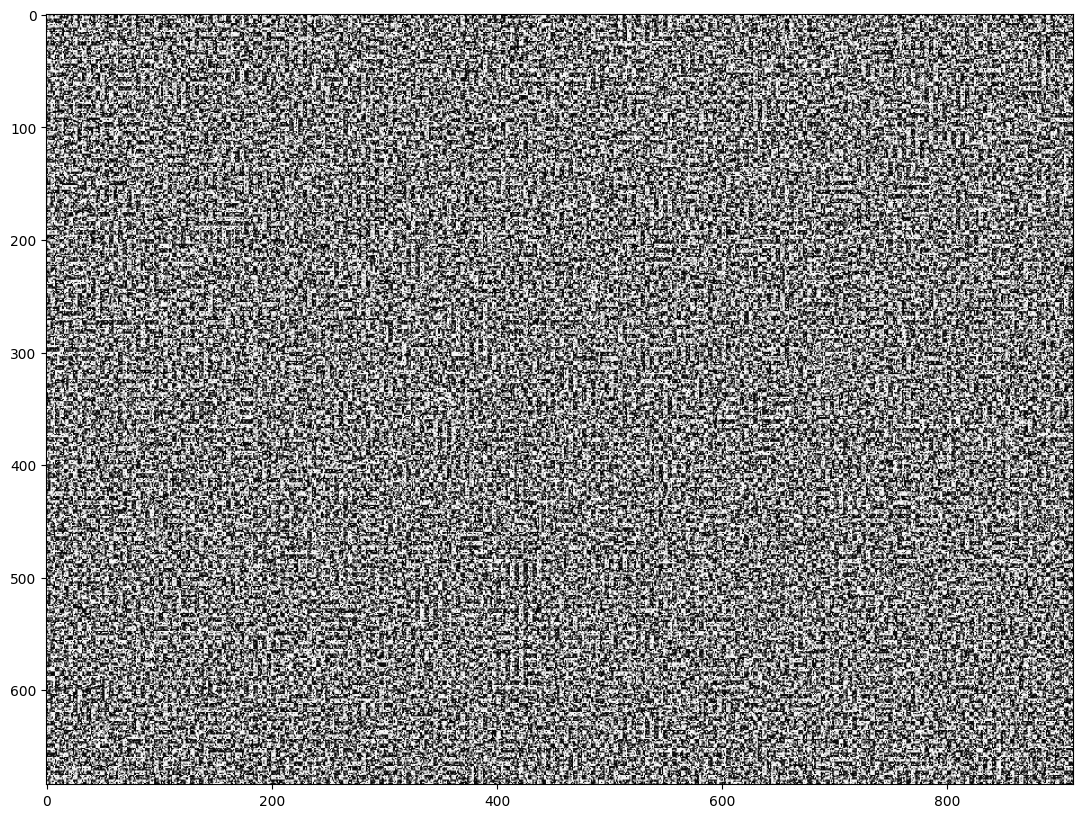

In [27]:
from IPython.display import clear_output
import gc
from metric_utils import *
# from loss_utils import *
eps = 1e-2
torch.cuda.empty_cache()
p = 'smooth'
g_loss = GLoss(device=device, p=p)
# grad_variance = GradientVariance(device=device, patch_size=8)
# # ciede2000 = CIEDE2000Loss(device=device)
# # color_loss = ColorDiffLoss(device=device, mode='lab')
# # gamma_correction_loss = GammaCorrectionLoss()
# # smape_loss = SmapeLoss(eps=eps, p=2)
# # sobel_loss = SobelLoss(p='smooth')
# # ssim_loss = SSIMLoss()
# tv_loss = TVLoss(device=device, p=1, mode='l')
# # sobel_smape_loss = SobelSmapeLoss()

base_image_rgb_torch = torch.tensor(base_image_rgb.astype(float), dtype=torch.float, device=device).permute(2, 0, 1).unsqueeze(0) / (255 * 100)
quant_image_rgb_noisy = quant_image_rgb + 3 * np.random.randn(*quant_image_rgb.shape)
quant_image_rgb_torch = torch.tensor(quant_image_rgb_noisy.astype(float), dtype=torch.float, device=device).permute(2, 0, 1).unsqueeze(0) / (255 * 100)
# quant_image_rgb_torch = torch.randn(quant_image_rgb_torch.size(), device=device, dtype=torch.float)

ssims = []
psnrs = []
values = defaultdict(list)

quant_image_rgb_noisy_clone = quant_image_rgb_torch.clone()
quant_image_rgb_noisy_clone.requires_grad = True

# tv_smape_loss = TVSmapeLoss(p=2, use_detach=False, use_pow=False, eps=eps)
optimizer = torch.optim.Adam([quant_image_rgb_noisy_clone], lr=5e-3)

gradients = defaultdict(list)
gradients_mean = defaultdict(list)

quant_image_rgb_noisy_clone.register_hook(lambda grad: gradients['gloss'].append(grad.abs().max().item()))
quant_image_rgb_noisy_clone.register_hook(lambda grad: gradients_mean['gloss'].append(grad.abs().mean().item()))

for i in range(100):
    optimizer.zero_grad()
    
    loss = 0

    gloss_value = g_loss(quant_image_rgb_noisy_clone, base_image_rgb_torch)
    loss = loss + gloss_value
    values['gloss_value'].append(gloss_value.detach().cpu().item())
    # quant_image_rgb_noisy_clone_2 = quant_image_rgb_noisy_clone.clone()
    # quant_image_rgb_noisy_clone_2.register_hook(lambda grad: gradients['grad_variance'].append(grad.abs().max()))
    # quant_image_rgb_noisy_clone_2.register_hook(lambda grad: gradients_mean['grad_variance'].append(grad.abs().mean()))

    # grad_value = grad_variance(quant_image_rgb_noisy_clone_2, base_image_rgb_torch)
    # loss = loss + 500 * grad_value
    # # print("Grad Variance value: ", 500 * grad_value)

    loss.backward()
    optimizer.step()
    gc.collect()
    del loss# quant_image_rgb_noisy_clone_2
    torch.cuda.empty_cache()

    if (i + 1) % 10 == 0 or i == 0:
        clear_output(True)
        ssim_score = calculate_ssim(
        np.clip(quant_image_rgb_noisy_clone.detach()[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255), 
        np.clip(base_image_rgb_torch[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255)
        )
        psnr_score = calculate_psnr(
            np.clip(quant_image_rgb_noisy_clone.detach()[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255), 
            np.clip(base_image_rgb_torch[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255)
        )
        
        # key = f'{1}_{False}_{False}'
        ssims.append(ssim_score)
        psnrs.append(psnr_score)
        plot_metrics(ssims, psnrs, p=p)
        print(ssim_score, psnr_score)
    torch.cuda.empty_cache()


quant = np.clip(quant_image_rgb_noisy_clone.detach()[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255).astype(np.uint8)
base = np.clip(base_image_rgb_torch.detach()[0].permute(1, 2, 0).cpu().numpy() * 255 * 100, 0, 255).astype(np.uint8)

fig = plt.figure(figsize=(20, 10))
plt.imshow(np.abs(quant - base).mean(-1), cmap='gray')

plt.imsave("quant.png", quant)
plt.imsave("base.png", base)

del quant_image_rgb_noisy_clone, optimizer
torch.cuda.empty_cache()
for key, value in gradients_mean.items():
    fig = px.line(value, markers=True, title="Mean gradients for " + key.upper())
    fig.update_layout(showlegend=False)
    fig.show()

for key, value in values.items():
    fig = px.line(value, markers=True, title=key.upper())
    fig.update_layout(showlegend=False)
    fig.show()